In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
data = np.load('HeatExchanger/results/predictions_and_targets.npz')

# branch inputs
pred = data['predictions']
gt = data['targets'][:, :, 0:-1]

print("Pred shape:", pred.shape)
print("GT shape:", gt.shape)

Pred shape: (310, 3977, 4)
GT shape: (310, 3977, 4)


In [16]:
# compute relative l2 error for each channel [# samples, # mesh points, # channels]
def rel_l2_error(pred, gt):
    # compute relative l2 error
    err = np.linalg.norm(pred - gt, axis=-1) / np.linalg.norm(gt, axis=-1)
    return err

In [18]:
# compute relative l2 error for each channel
err0 = rel_l2_error(pred[:, :, 0], gt[:, :, 0])
err1 = rel_l2_error(pred[:, :, 1], gt[:, :, 1])
err2 = rel_l2_error(pred[:, :, 2], gt[:, :, 2])
err3 = rel_l2_error(pred[:, :, 3], gt[:, :, 3])

# compute mean relative l2 error for each channel
mean_err0 = np.mean(err0, axis=0)
mean_err1 = np.mean(err1, axis=0)
mean_err2 = np.mean(err2, axis=0)
mean_err3 = np.mean(err3, axis=0)

# compute standard deviation of relative l2 error for each channel
std_err0 = np.std(err0, axis=0) * 100
std_err1 = np.std(err1, axis=0) * 100
std_err2 = np.std(err2, axis=0) * 100
std_err3 = np.std(err3, axis=0) * 100

# print mean and std of relative l2 error for each channel
print(f'Mean relative L2 error for channel 0: {mean_err0:.4f} +/- {std_err0:.4f}')
print(f'Mean relative L2 error for channel 1: {mean_err1:.4f} +/- {std_err1:.4f}')
print(f'Mean relative L2 error for channel 2: {mean_err2:.4f} +/- {std_err2:.4f}')
print(f'Mean relative L2 error for channel 3: {mean_err3:.4f} +/- {std_err3:.4f}')

Mean relative L2 error for channel 0: 0.0080 +/- 0.0146
Mean relative L2 error for channel 1: 0.0145 +/- 0.0291
Mean relative L2 error for channel 2: 0.0102 +/- 0.0274
Mean relative L2 error for channel 3: 0.0052 +/- 0.0384


In [19]:
import pandas as pd

df = pd.DataFrame()

df['ch0'] = err0 * 100
df['ch1'] = err1 * 100
df['ch2'] = err2 * 100
df['ch3'] = err3 * 100

# compute the mean over all channel per sample
df['mean'] = df.mean(axis=1)

# get the idx of the maximum mean and minimum mean also 50th percentile
df['50th_percentile'] = df['mean'].quantile(0.5)
# find the idx for 50th percentile
percentile_idx = df['mean'].sub(df['50th_percentile']).abs().idxmin()
print(f"Sample with 50th percentile mean relative error: {percentile_idx}, Mean: {df['mean'][percentile_idx]}")

print(df.iloc[percentile_idx])

Sample with 50th percentile mean relative error: 8, Mean: 0.9359716773033142
ch0                0.787585
ch1                1.441303
ch2                1.008520
ch3                0.506479
mean               0.935972
50th_percentile    0.936184
Name: 8, dtype: float64


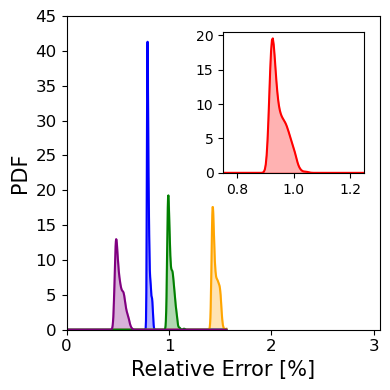

In [38]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(1, 1, figsize=(4, 4))

p = err0 * 100
uz = err1 * 100
uy = err2 * 100
ux = err3 * 100
mean_vals = df['mean']

p_kde = gaussian_kde(p)
uz_kde = gaussian_kde(uz)
uy_kde = gaussian_kde(uy)
ux_kde = gaussian_kde(ux)
mean_kde = gaussian_kde(mean_vals)


x_eval = np.linspace(0, max(p.max(), uz.max(), uy.max(), ux.max(), mean_vals.max()), 500)
p_pdf = p_kde(x_eval)
uz_pdf = uz_kde(x_eval)
uy_pdf = uy_kde(x_eval)
ux_pdf = ux_kde(x_eval)
mean_pdf = mean_kde(x_eval)

axs.plot(x_eval, p_pdf, color='blue')
axs.fill_between(x_eval, p_pdf, color='blue', alpha=0.3)

axs.plot(x_eval, uz_pdf, color='orange')
axs.fill_between(x_eval, uz_pdf, color='orange', alpha=0.3)

axs.plot(x_eval, uy_pdf, color='green')
axs.fill_between(x_eval, uy_pdf, color='green', alpha=0.3)

axs.plot(x_eval, ux_pdf, color='purple')
axs.fill_between(x_eval, ux_pdf, color='purple', alpha=0.3)

inset = axs.inset_axes([0.5, 0.5, 0.45, 0.45])  # Adjust as needed (x0, y0, w, h)
inset.plot(x_eval, mean_pdf, color='red')
inset.fill_between(x_eval, mean_pdf, alpha=0.3, color='red')
inset.set_xlim(0.75, 1.25)  # Zoomed-in x-range for mean
inset.set_ylim(0, max(mean_pdf) * 1.05)

axs.set_xlabel('Relative Error [%]', fontsize=15)
axs.set_ylabel('PDF', fontsize=15)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.set_xlim(0, x_eval.max()+1.5)
axs.set_ylim(0, 45.0)

plt.tight_layout()
plt.savefig('HeatExchanger/analysis/heat_exchanger_pdf.png', dpi=300)
plt.show()